Using XGBoost to predict individuals' ethnic breakdown using G25 coordinates of both modern and ancient DNA samples

In [1]:
require(rio)
require(tidyverse)
require(xgboost)
require(ggrepel)
require(cowplot)

Loading required package: xgboost


Attaching package: ‘xgboost’


The following object is masked from ‘package:dplyr’:

    slice


Loading required package: ggrepel

Loading required package: cowplot


Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp




In [75]:
bad = as_tibble(import("../Genetics/G25/Data/CSV/Eurasia/G25_BA.csv"))
iad = as_tibble(import("../Genetics/G25/Data/CSV/Eurasia/G25_IA.csv"))
mad = as_tibble(import("../Genetics/G25/Data/CSV/Eurasia/G25_MA.csv"))
mod = as_tibble(import("../Genetics/G25/Data/CSV/Eurasia/Global25_PCA_modern_scaled.txt"))

In [4]:
head(bad,1)
head(iad,1)
head(mad,1)
head(mod,1)

sample,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Albania_EBA_o1:I14689,0.122929,0.118817,0.033564,0.045543,-0.008309,0.01255,0.008225,-0.000462,-0.026384,⋯,-0.009679,-0.014212,0.003927,0.010307,-0.00988,-0.010731,-0.003091,0.014666,0.010845,-0.011496


sample,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Albania_BA_IA:I14688,0.119514,0.160454,0.02225,-0.028101,0.024312,-0.017012,0.00141,-0.001385,-0.001841,⋯,-0.016176,-0.008736,0.003674,0.003645,-0.004502,-0.013726,0.009645,-0.001849,0.011809,-0.011855


sample,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Albania_Medieval:I13839,0.125205,0.153345,0.016216,-0.036176,0.03139,-0.013108,0,0.002077,0.007772,⋯,-0.01074,0.008996,0.004307,0.006536,-0.016508,-0.007237,0.001113,0.005053,-0.001205,0.001676


sample,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,⋯,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Abazin:KCHE-1032,0.10927,0.072103,-0.023004,-0.016796,-0.028005,0.003347,0.003055,-0.010384,-0.049904,⋯,-0.01074,-0.001173,-0.004054,-0.006662,0.023386,0.004742,-0.000124,-0.000863,-0.010965,-0.001916


In [76]:
colnames(mod) = colnames(bad)
myptrna = "^.+(?=:)"
myptrnb = "^\\w+?_\\w+?(?=[_:\\.])"
mod = mod %>% mutate(sample = str_extract(sample,myptrna))
bad = bad %>% mutate(sample = str_extract(sample,myptrnb))
iad = iad %>% mutate(sample = str_extract(sample,myptrnb))
mad = mad %>% mutate(sample = str_extract(sample,myptrnb))

In [77]:
mod %>% count(sample,sort = TRUE) %>% head(20)

sample,n
<chr>,<int>
Dutch,166
Swedish,101
Greek_Crete,100
Irish,85
Danish,81
German,79
German_Erlangen,67
Lak,52
Moldovan,42


In [78]:
bad %>% count(sample,sort = TRUE) %>% head(10)

sample,n
<chr>,<int>
Czech_EBA,100
Poland_Trzciniec,66
Czech_CordedWare,41
Czech_BellBeaker,34
Armenia_LBA,30
England_BellBeaker,27
Serbia_Mokrin,27
Israel_MLBA,26
Sweden_Gotland,26


In [79]:
iad %>% count(sample,sort = TRUE) %>% head(10)

sample,n
<chr>,<int>
England_MIA,122
Armenia_LBA,42
England_EIA,32
England_EastYorkshire,30
Mongolia_EIA,25
Czech_IA,23
Poland_Kowalewko,23
Kazakhstan_Tasmola,19
Iran_Hasanlu,18


In [80]:
mad %>% count(sample,sort = TRUE) %>% head(10)

sample,n
<chr>,<int>
Sweden_Viking,118
England_EarlyMedieval,89
Denmark_Viking,68
Italy_Medieval,38
Estonia_EarlyViking,34
Ireland_Kilteasheen,30
England_Viking,29
Vladimir_MA,28
Mongolia_Arkhangai,26


In [16]:
ppl = as_tibble(import("../Genetics/G25/Data/People/All.txt"))

In [17]:
ppl

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
RN:RN2020,0.100164,0.135065,-0.003771,-0.041667,0.009540,-0.017570,-0.004465,-0.003000,0.008590,⋯,-0.013657,-0.016168,0.003801,0.001508,-0.005378,-0.002870,-0.002226,-0.001109,-0.002771,-0.005987
TP:TP2022,0.127482,0.125926,0.072407,0.060724,0.033852,0.024821,0.010340,0.006692,-0.005931,⋯,0.007292,0.004955,-0.000380,0.004274,0.004877,-0.008610,-0.001978,0.006532,-0.006266,-0.001676
MN:MN2020,0.097888,0.141159,-0.002640,-0.051034,0.009540,-0.017012,-0.007285,0.000000,0.006954,⋯,-0.005701,-0.017732,0.002660,-0.002388,-0.004002,0.000749,-0.007048,-0.002095,0.003976,-0.000120
MD:MD2022,0.099026,0.129988,-0.001886,-0.041667,0.011079,-0.015060,0.002350,0.001846,0.011862,⋯,-0.003978,0.001956,0.000380,-0.000628,-0.005753,-0.006738,-0.001978,-0.001849,-0.001807,-0.008143


In [19]:
smpls = as_tibble(import("../Genetics/G25/Data/TXT/By Country/Averages/Modern_averages.txt"))

In [20]:
nrow(smpls)
smpls %>% sample_n(10)

[1] 48

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Lithuanian_VA:average,0.1344249,0.1257226,0.0824762,0.0750975,0.0433311,0.0278890,0.0099878,0.0148840,-0.0020454,⋯,0.0029435,0.0061411,-0.0005702,0.0023129,0.0061155,-0.0037310,-0.0048100,0.0072346,-0.0078805,-0.0008622
Ukrainian_Zhytomyr:average,0.1313841,0.1272314,0.0710604,0.0592936,0.0371497,0.0232674,0.0104747,0.0132521,-0.0029216,⋯,-0.0041293,0.0045820,-0.0006336,0.0036631,0.0006433,-0.0078433,-0.0031266,0.0046306,-0.0027714,0.0019331
Ashkenazi_Belarussia:average,0.1019155,0.1339716,-0.0073393,-0.0395799,0.0107712,-0.0144595,-0.0010123,-0.0010294,0.0057267,⋯,0.0027944,0.0018154,-0.0003409,0.0014889,-0.0012602,-0.0038586,-0.0007705,0.0027399,0.0015665,-0.0002949
Ashkenazi_Lithuania:average,0.0998539,0.1327575,-0.0092224,-0.0403750,0.0094843,-0.0141475,-0.0005555,-0.0011750,0.0060613,⋯,0.0034595,0.0016001,0.0001612,0.0004455,-0.0031721,-0.0032555,-0.0033497,0.0029245,0.0024428,-0.0010560
Serbian:average,0.1273334,0.1372290,0.0400240,0.0148299,0.0314974,0.0045957,0.0048738,0.0066720,-0.0011737,⋯,-0.0008358,0.0040476,0.0005894,0.0043011,-0.0024468,-0.0083168,-0.0017151,0.0048925,0.0003720,-0.0020097
Cossack_Ukrainian:average,0.1354490,0.1167860,0.0716530,0.0600780,0.0338520,0.0231480,0.0112810,0.0106150,0.0030680,⋯,0.0019890,0.0003910,0.0051940,0.0035200,0.0033770,-0.0096080,-0.0023490,0.0040670,-0.0068680,0.0005990
North_Ossetian:average,0.1041480,0.0888588,-0.0311125,-0.0251132,-0.0383148,0.0057170,0.0117505,-0.0006925,-0.0539945,⋯,-0.0226065,0.0027380,-0.0059542,-0.0098988,0.0188840,0.0060518,0.0019472,-0.0007395,-0.0084048,-0.0027242
Ukrainian_Rivne:average,0.1301377,0.1243461,0.0702284,0.0625543,0.0392208,0.0211027,0.0096616,0.0104867,-0.0003636,⋯,-0.0009428,0.0055342,-0.0017314,0.0032261,-0.0006670,-0.0049217,-0.0036958,0.0048341,-0.0043109,0.0001066
Ashkenazi_Ukraine:average,0.0994244,0.1351162,-0.0055060,-0.0401166,0.0120483,-0.0142652,-0.0010928,0.0001154,0.0077720,⋯,-0.0018297,-0.0043223,-0.0000190,0.0012758,-0.0046772,-0.0031258,-0.0025904,0.0007702,0.0021028,0.0010059


In [21]:
myfun = function (mydf,e = 0.75,d = 5,a = 0.5,g = 0,l = 0.5) {
        mydata = mydf %>% mutate(label = as.numeric(as.factor(sample)) - 1) %>% select(-sample)
        nclas = length(unique(mydata$label))
        print(paste0("Number of classes: ",nclas))
        smpl = sample(1:nrow(mydata),.75*nrow(mydata))
        print("Split into test and train samples")
        train_data = mydata[smpl,]
        test_data = mydata[-smpl,]
        print(dim(train_data))
        print(dim(test_data))
        td = data.matrix(train_data %>% select(-label))
        tl = train_data$label
        ttd = data.matrix(test_data %>% select(-label))
        ttl = test_data$label
        dtrain = xgb.DMatrix(data = td,label = tl)
        dtest = xgb.DMatrix(data = ttd,label = ttl)
        print("Starting XGBoost training")
        obj = "multi:softprob"
        mymod = xgb.train(data = dtrain,
                          eta = e,
                          max_depth = d,
                          nround = 100,
                          subsample = .5,
                          colsample_bytree = .5,
                          alpha = a,
                          gamma = g,
                          lambda = l,
                          objective = obj,
                          num_class = nclas,
                          nthread = 4,
                          watchlist = list(train = dtrain,test = dtest),
                          print_every_n = 25,
                          verbose = 1)
        mypred = predict(mymod,dtest)
        nclas = ifelse(str_ends(obj,"max"),1,nclas)
        mypred = mypred %>% matrix(ncol = nclas,byrow = TRUE) %>% as_tibble() %>% mutate(row = row_number()) %>% bind_cols(label = ttl)
        colnames(mypred) = c(as.character(0:(nclas-1)),"row","label")
        myd = pivot_longer(mypred,cols = !matches("^[rl]"),names_to = "variable",values_to = "value")
        myd = myd %>% group_by(row,label) %>% mutate(maxval = max(value)) %>% ungroup()
        mydd = myd %>% dplyr::filter(value == maxval)
        print(sample_n(mydd,15))
        err = with(mydd,mean(label != variable))
        print(paste0("test-error = ", err))
        return(mymod)
    }

In [22]:
mypfun = function(mymdl,mypd,mynd) {
    smpls = unique(na.omit(mypd$sample))
    #nclas = 1
    nclas = length(smpls)
    print(paste0("Using ",nclas," populations"))
    mypred = predict(mymdl,xgb.DMatrix(data = data.matrix(mynd %>% select(-V1)),label = 1:nrow(mynd)))
    mypred = mypred %>% matrix(ncol = nclas,byrow = TRUE) %>% as_tibble() %>% mutate(row = row_number())
    colnames(mypred) = c(as.character(0:(nclas-1)),"row")
    myd = pivot_longer(mypred,cols = !matches("^row"),names_to = "variable",values_to = "value")
    myd = myd %>% group_by(row) %>% mutate(tot = sum(value)) %>% mutate(value = value/tot) %>% ungroup()
    myd = myd %>% arrange(row,desc(value)) %>% dplyr::filter(value >= 0.01)
    #mprd = myd %>% inner_join(mynd %>% select(V1) %>% mutate(row = row_number()),by = "row") %>% inner_join(data.frame(value = 1:length(smpls),eth = smpls))
    mprd = myd %>% inner_join(mynd %>% select(V1) %>% mutate(row = row_number()),by = "row") %>% inner_join(data.frame(variable = as.character(1:length(smpls)),eth = smpls))
    mprd = mprd %>% mutate(name = str_extract(V1,"^.+(?=:)"),value = paste0(round(100*value,1),"%")) %>% select(name,eth,value)
    print(mprd %>% as.data.frame)
    return(mprd)
}

In [55]:
mythm = theme_minimal_hgrid(7,color = "gray45",line_size = 0.1) + theme(plot.background = element_rect(fill = "gray25"))

In [24]:
plotfun = function(mydata,lsz = 2,nrw = 1) {
    ggplot(mydata,aes(as.numeric(str_remove(value,"%")),I(1))) + 
        geom_label_repel(stat = "identity",aes(label = eth,fill = as.numeric(as.factor(name))),size = lsz,force = 4) + 
        scale_x_log10() + 
        facet_wrap(facets = ~ name,nrow = nrw) + 
        #coord_cartesian(ylim = c(3,8)) + 
        coord_flip() + 
        guides(fill = "none") + 
        scale_fill_distiller() + 
        #scale_fill_viridis_c(option = "H") + 
        mythm + xlab("%") + ylab("") + 
        theme(axis.text.x = element_blank(),axis.line.x = element_blank(),axis.ticks.x = element_blank())
    }

Modern Populations

In [25]:
mdl = myfun(na.omit(mod),e = 0.5,a = 1,l = 10)

[1] "Number of classes: 391"
[1] "Split into test and train samples"
[1] 3582   26
[1] 1194   26
[1] "Starting XGBoost training"
[1]	train-mlogloss:5.539873	test-mlogloss:5.591090 
[26]	train-mlogloss:2.325501	test-mlogloss:3.355629 
[51]	train-mlogloss:1.489409	test-mlogloss:3.001001 
[76]	train-mlogloss:1.103367	test-mlogloss:2.866348 
[100]	train-mlogloss:0.900641	test-mlogloss:2.801290 


Warning message:
“The `x` argument of `as_tibble.matrix()` must have unique column names if
`.name_repair` is omitted as of tibble 2.0.0.
ℹ Using compatibility `.name_repair`.”


# A tibble: 15 × 5
     row label variable  value maxval
   <int> <dbl> <chr>     <dbl>  <dbl>
 1   646   186 142      0.295  0.295 
 2  1152   376 165      0.190  0.190 
 3    58    24 22       0.183  0.183 
 4  1006   318 260      0.0937 0.0937
 5   897   268 193      0.0968 0.0968
 6   425   132 130      0.359  0.359 
 7  1122   361 226      0.604  0.604 
 8    90    33 33       0.271  0.271 
 9   268    82 82       0.622  0.622 
10   401   111 103      0.124  0.124 
11   353   102 183      0.595  0.595 
12   419   123 369      0.0882 0.0882
13   169    53 280      0.196  0.196 
14   537   158 166      0.119  0.119 
15   806   237 237      0.0366 0.0366
[1] "test-error = 0.64321608040201"


In [27]:
mprd = mypfun(mdl,mod,ppl)

[1] "Using 391 populations"


Joining with `by = join_by(variable)`


   name                   eth value
1    RN   Ashkenazi_Lithuania 67.3%
2    RN      Ashkenazi_Russia  8.4%
3    RN     Ashkenazi_Germany  4.5%
4    RN         Armenian_Urfa  2.4%
5    RN      Italian_Calabria  1.4%
6    TP   Russian_Leshukonsky 13.3%
7    TP Ukrainian_Zakarpattia 10.7%
8    TP        Russian_Ryazan  4.1%
9    TP                Bedzan  3.1%
10   TP           Palestinian  3.1%
11   TP  Russian_Krasnoborsky  2.1%
12   TP              Tuvinian  1.9%
13   TP         Russian_Pskov  1.7%
14   TP      Russian_Smolensk  1.5%
15   TP      Ukrainian_Dnipro  1.4%
16   TP               Cypriot  1.1%
17   TP         Georgian_West    1%
18   TP           German_East    1%
19   TP         Lithuanian_SZ    1%
20   MN   Ashkenazi_Lithuania 16.3%
21   MN      Ashkenazi_Russia 13.9%
22   MN  Ashkenazi_Belarussia  5.7%
23   MN      Ashkenazi_Poland  3.4%
24   MN     Ashkenazi_Germany  2.6%
25   MN                 Irish  2.2%
26   MN         Armenian_Urfa  1.3%
27   MN       Italian_Bergam

In [30]:
options(repr.plot.width = 5, repr.plot.height = 3, repr.plot.res = 400)

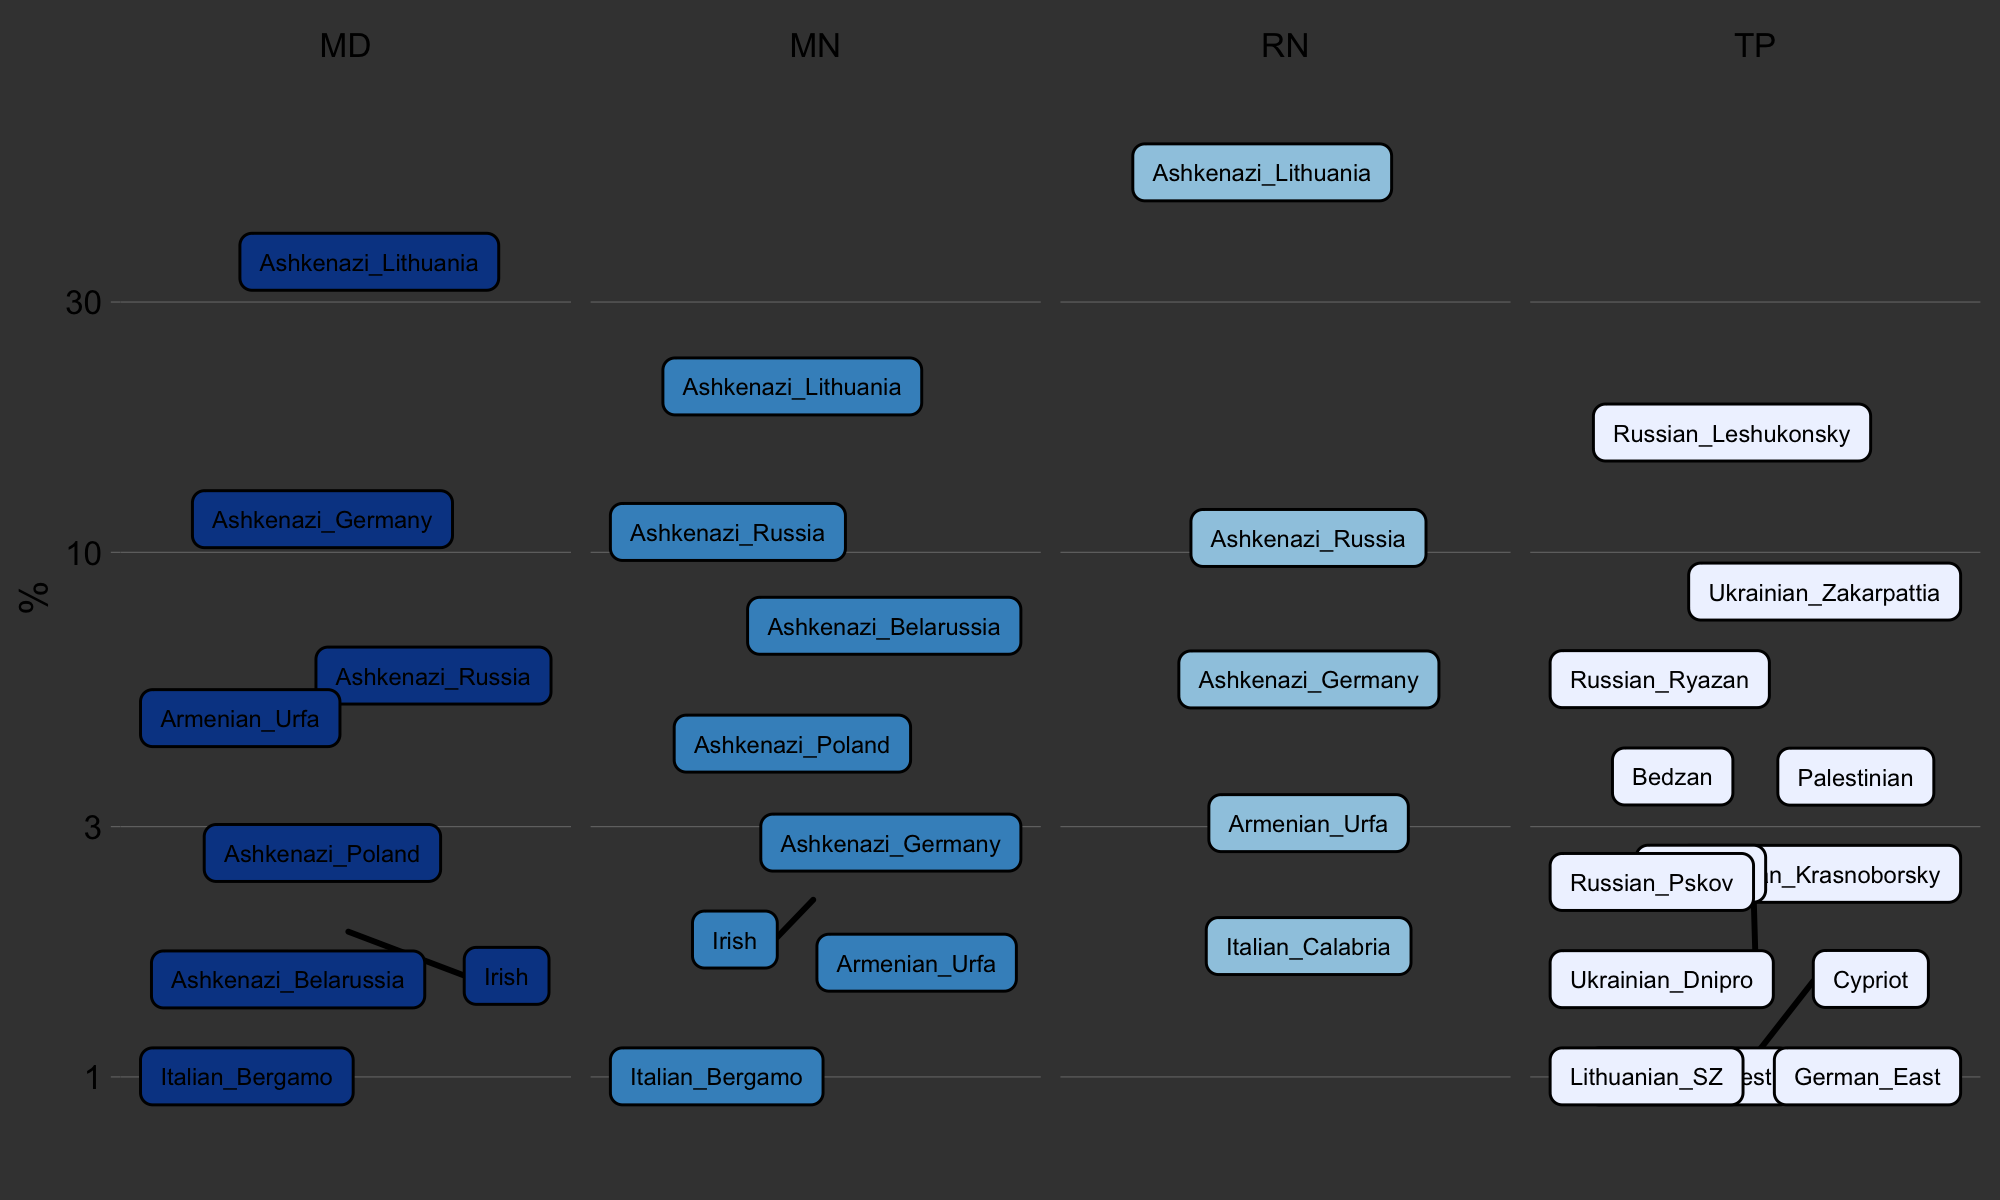

In [56]:
plotfun(mprd,lsz = 1.5)

Bronze Age

In [81]:
mdl = myfun(na.omit(bad),e = 1,a = 1,l = 10)

[1] "Number of classes: 233"
[1] "Split into test and train samples"
[1] 1068   26
[1] 357  26
[1] "Starting XGBoost training"
[1]	train-mlogloss:4.905918	test-mlogloss:4.961496 
[26]	train-mlogloss:2.299664	test-mlogloss:3.375801 
[51]	train-mlogloss:1.756058	test-mlogloss:3.285760 
[76]	train-mlogloss:1.505711	test-mlogloss:3.289410 
[100]	train-mlogloss:1.363694	test-mlogloss:3.290941 
# A tibble: 15 × 5
     row label variable  value maxval
   <int> <dbl> <chr>     <dbl>  <dbl>
 1   290   177 177      0.384  0.384 
 2   172    86 166      0.547  0.547 
 3   222   134 134      0.0703 0.0703
 4   350   225 217      0.218  0.218 
 5   288   177 177      0.793  0.793 
 6   328   203 27       0.849  0.849 
 7    51    26 165      0.0881 0.0881
 8   134    55 19       0.344  0.344 
 9   316   198 198      0.879  0.879 
10    79    27 27       0.484  0.484 
11   277   163 163      0.0674 0.0674
12   221   132 27       0.143  0.143 
13   244   137 27       0.643  0.643 
14   334   208 210 

In [82]:
mprd = mypfun(mdl,bad,ppl)

[1] "Using 233 populations"


Joining with `by = join_by(variable)`


   name                    eth value
1    RN             Tiryns_LBA  1.7%
2    RN          GlykaNera_LBA  1.6%
3    RN       Armenia_Lchashen  1.5%
4    RN Morocco_Iberomaurusian  1.5%
5    RN           Italy_Sicily  1.3%
6    RN            Armenia_MBA  1.2%
7    RN            Italy_North  1.2%
8    RN          Bulgaria_MLBA  1.1%
9    RN             Croatia_BA  1.1%
10   RN            Albania_MBA  1.1%
11   TP             Poland_TRB 58.1%
12   TP       Czech_CordedWare 30.4%
13   MN          GlykaNera_LBA  2.2%
14   MN       Armenia_Lchashen  1.7%
15   MN Morocco_Iberomaurusian  1.6%
16   MN           Italy_Sicily  1.4%
17   MN             Tiryns_LBA  1.4%
18   MN    Bulgaria_BeliBreyag  1.2%
19   MN            Hungary_EBA  1.2%
20   MN            Armenia_MBA  1.2%
21   MN            Hungary_MBA  1.2%
22   MN            Italy_North  1.1%
23   MD             Serbia_LBA  2.1%
24   MD            Armenia_MBA  1.4%
25   MD           Italy_Sicily  1.2%
26   MD       Armenia_Lchashen  1.2%
2

In [83]:
options(repr.plot.width = 5, repr.plot.height = 3, repr.plot.res = 400)

Warning message:
“ggrepel: 3 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 2 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


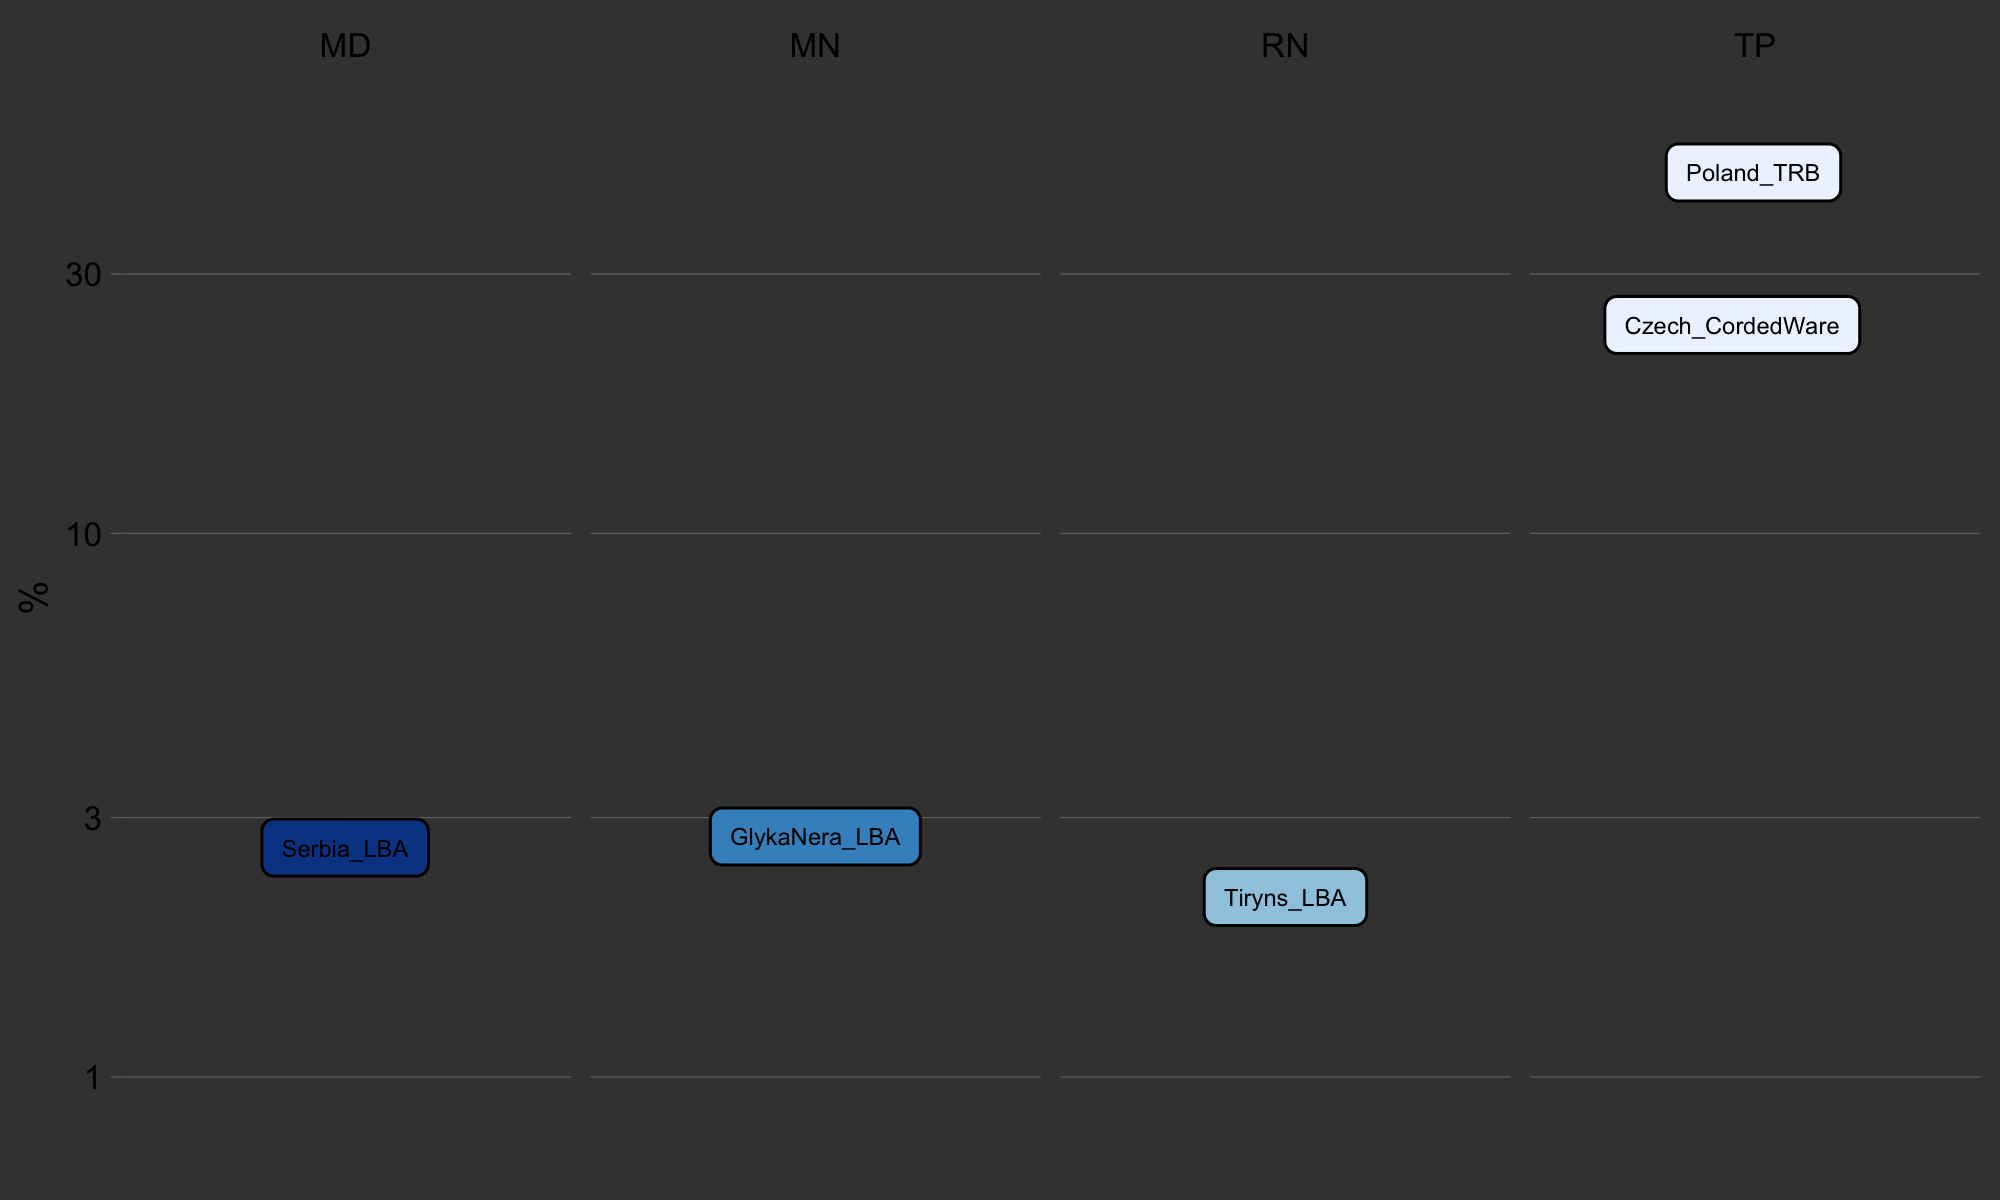

In [84]:
plotfun(mprd,lsz = 1.5)

In [60]:
mprd = mypfun(mdl,bad,smpls)

[1] "Using 225 populations"


Joining with `by = join_by(variable)`


                     name                     eth value
1    Ashkenazi_Belarussia     Bulgaria_BeliBreyag  4.8%
2    Ashkenazi_Belarussia             Lebanon_MBA  2.3%
3    Ashkenazi_Belarussia             Hungary_MBA  1.5%
4    Ashkenazi_Belarussia Ukraine_GlobularAmphora  1.4%
5    Ashkenazi_Belarussia             Armenia_MBA  1.2%
6     Ashkenazi_Lithuania             Lebanon_MBA  2.2%
7     Ashkenazi_Lithuania        Armenia_Lchashen  1.6%
8     Ashkenazi_Lithuania             Hungary_MBA  1.6%
9     Ashkenazi_Lithuania     Bulgaria_BeliBreyag  1.5%
10    Ashkenazi_Lithuania Ukraine_GlobularAmphora  1.4%
11    Ashkenazi_Lithuania      Slovakia_Mikusovce  1.3%
12    Ashkenazi_Lithuania             Armenia_MBA  1.2%
13    Ashkenazi_Lithuania            Iran_Hasanlu  1.1%
14      Ashkenazi_Ukraine             Lebanon_MBA  2.2%
15      Ashkenazi_Ukraine        Armenia_Lchashen  1.9%
16      Ashkenazi_Ukraine     Bulgaria_BeliBreyag  1.8%
17      Ashkenazi_Ukraine             Hungary_MB

In [61]:
options(repr.plot.width = 12, repr.plot.height = 12, repr.plot.res = 400)

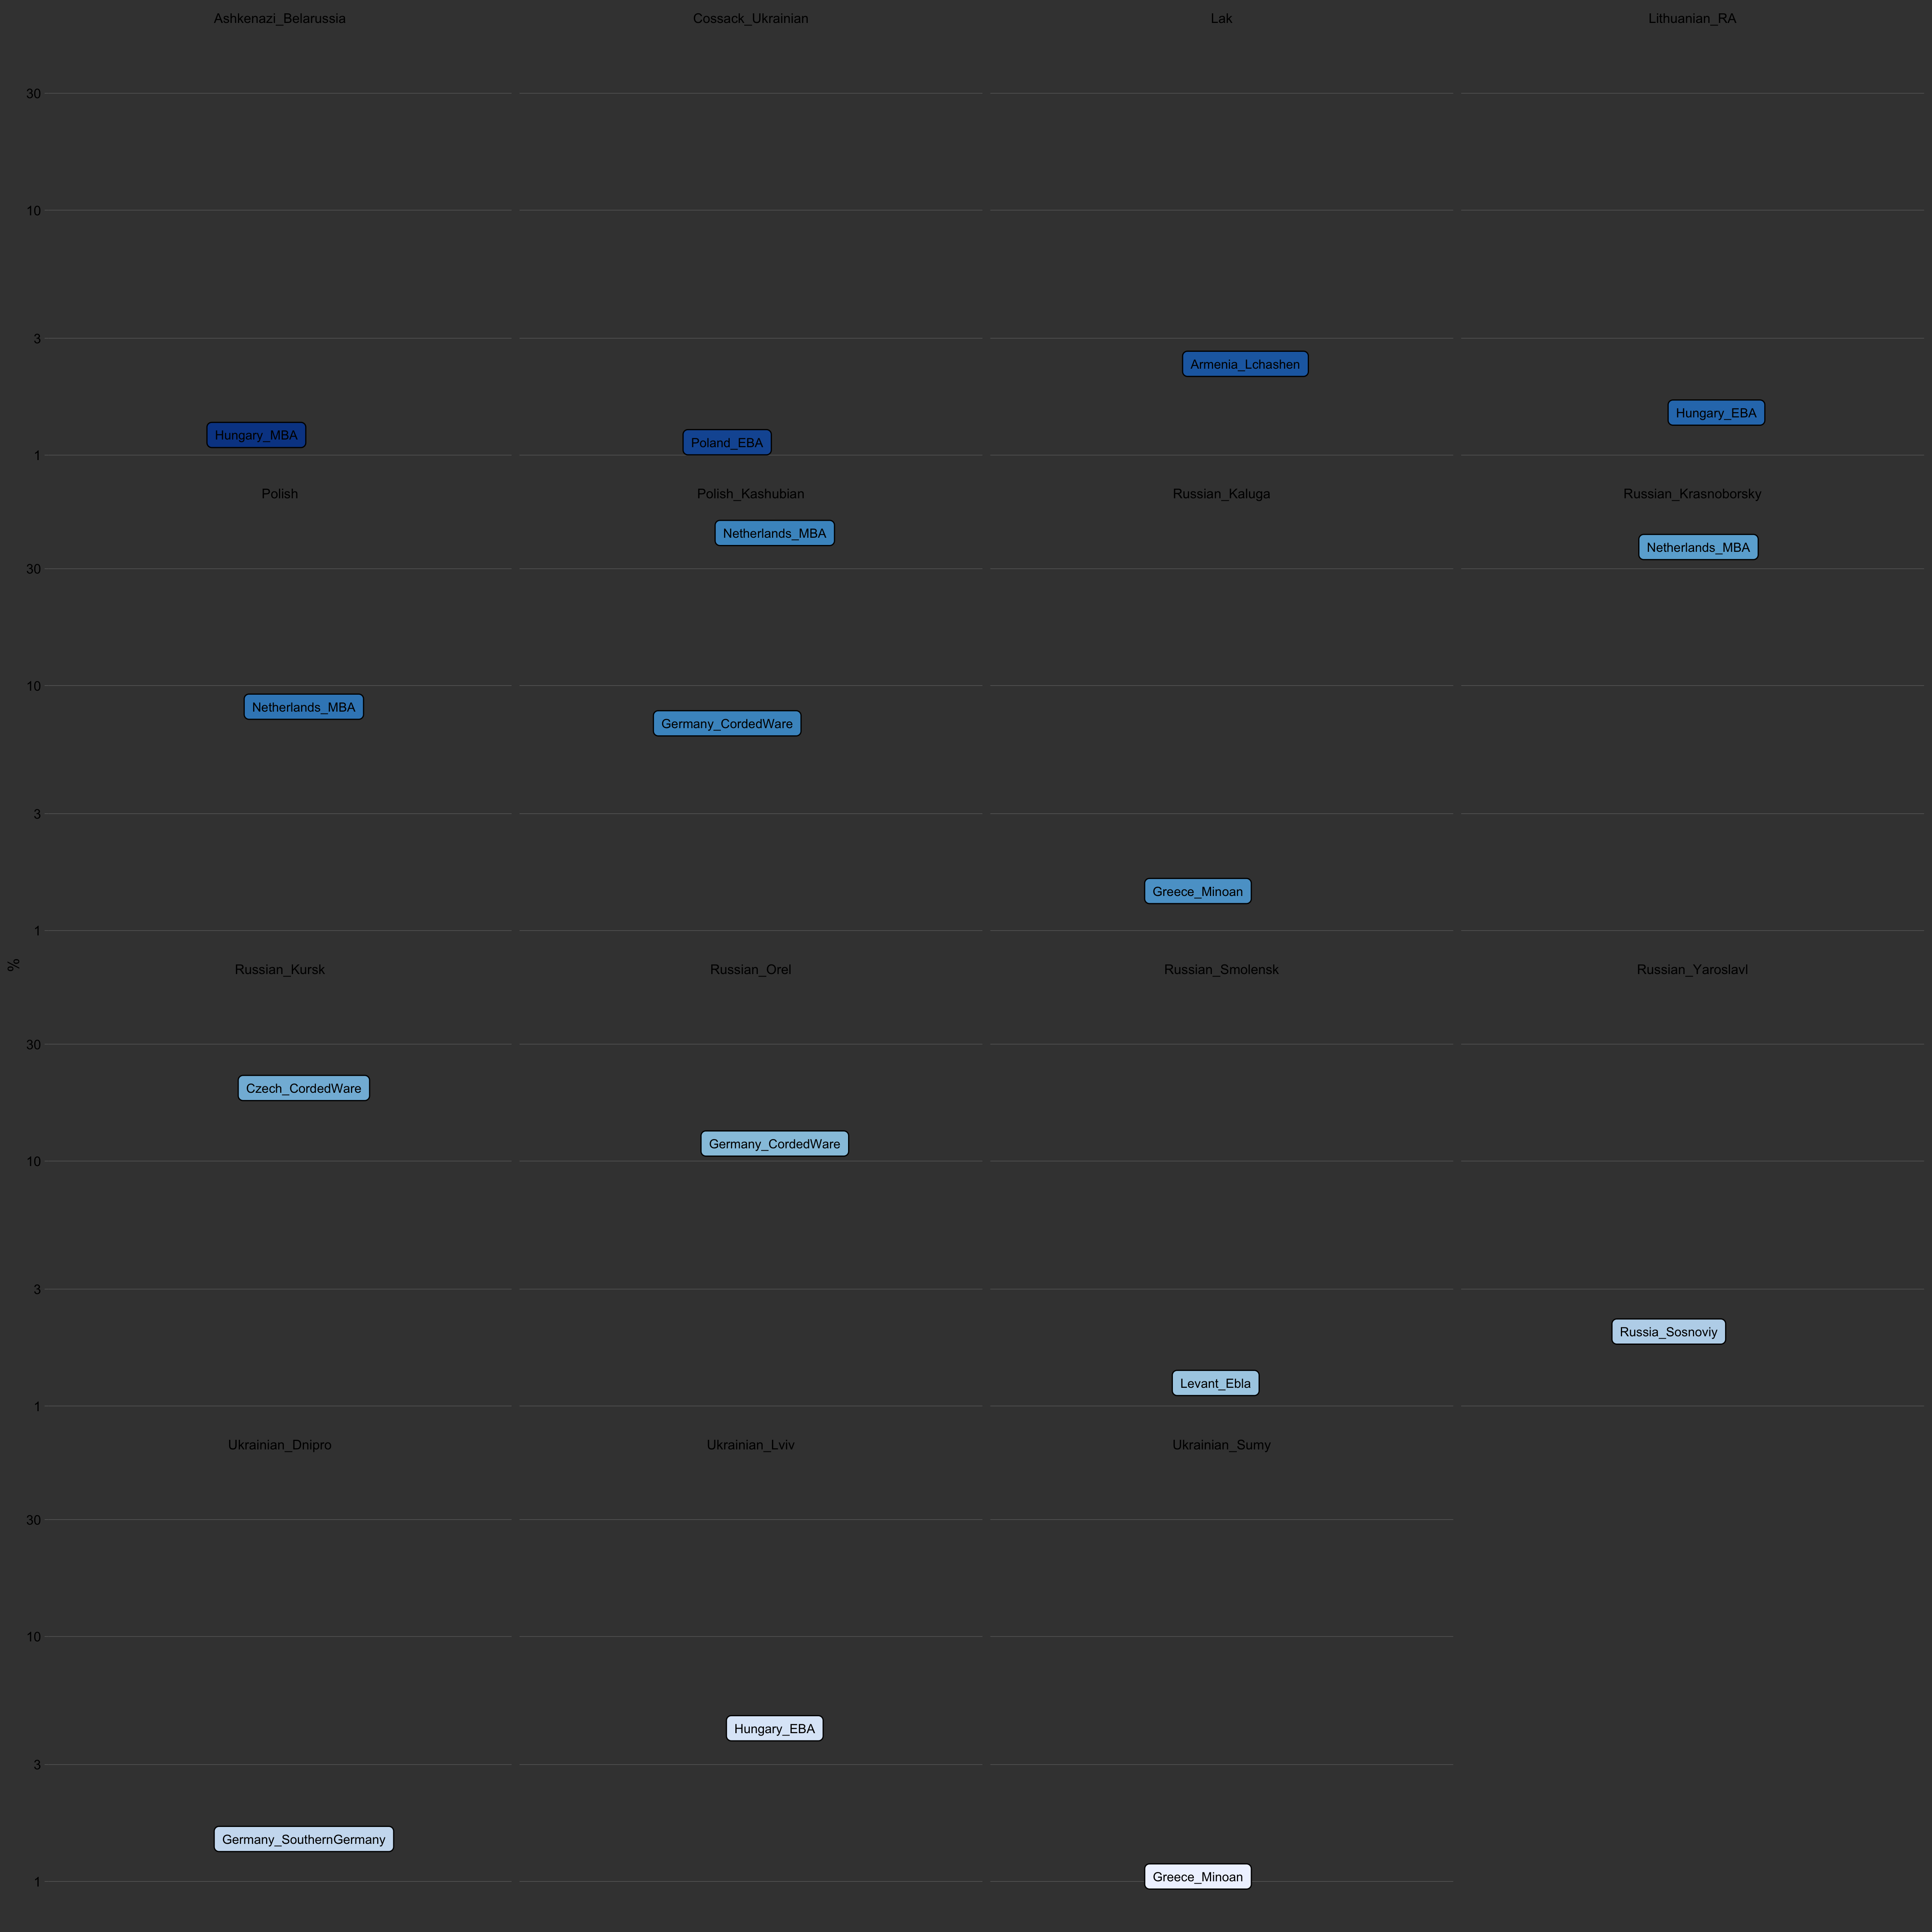

In [62]:
plotfun(mprd %>% sample_n(16),lsz = 2,nrw = 4)

IronAge

In [85]:
mdl = myfun(na.omit(iad),e = 0.5,a = 1,l = 10)

[1] "Number of classes: 129"
[1] "Split into test and train samples"
[1] 591  26
[1] 197  26
[1] "Starting XGBoost training"
[1]	train-mlogloss:4.441796	test-mlogloss:4.517207 
[26]	train-mlogloss:2.443545	test-mlogloss:3.240589 
[51]	train-mlogloss:1.891785	test-mlogloss:3.032313 
[76]	train-mlogloss:1.616264	test-mlogloss:2.970585 
[100]	train-mlogloss:1.459485	test-mlogloss:2.946440 
# A tibble: 15 × 5
     row label variable  value maxval
   <int> <dbl> <chr>     <dbl>  <dbl>
 1     4     5 38       0.318  0.318 
 2   109    44 44       0.647  0.647 
 3    36    22 26       0.596  0.596 
 4   111    44 117      0.116  0.116 
 5    78    26 26       0.530  0.530 
 6   164   104 104      0.163  0.163 
 7   160   100 58       0.0813 0.0813
 8   120    59 76       0.314  0.314 
 9   190   123 42       0.0385 0.0385
10   172   107 30       0.0950 0.0950
11   170   107 10       0.115  0.115 
12   182   117 43       0.119  0.119 
13   152    90 23       0.0710 0.0710
14    51    26 26    

In [86]:
mprd = mypfun(mdl,iad,ppl)

[1] "Using 129 populations"


Joining with `by = join_by(variable)`


   name                    eth value
1    RN   France_LesMarmousets  5.4%
2    RN         Italy_Sardinia  2.1%
3    RN            Slovakia_IA    2%
4    RN          Greece_Delphi  1.7%
5    RN Armenia_UrartianEmpire  1.7%
6    RN     ChannelIslands_EIA  1.6%
7    RN           Stockholm_IA  1.6%
8    RN      Moldova_Cimmerian  1.5%
9    RN        Iran_HajjiFiruz  1.3%
10   RN  Slovakia_BytcaHrabove  1.3%
11   RN           Iran_Hasanlu  1.2%
12   RN            Italy_Lazio  1.1%
13   RN     Turkey_Hellenistic  1.1%
14   RN            Hungary_EIA  1.1%
15   RN    Kazakhstan_Kipchak2    1%
16   RN  England_EastYorkshire    1%
17   TP  Slovakia_BytcaHrabove   20%
18   TP            Hungary_EIA  7.1%
19   TP              Norway_IA  5.5%
20   TP           Poland_Gaski  3.8%
21   TP       Poland_Kowalewko  2.7%
22   TP            Croatia_LIA  2.6%
23   TP             Romback_IA  2.5%
24   TP            Nordland_IA  1.6%
25   TP          Russia_Samara  1.3%
26   TP              Czech_LBA  1.1%
2

In [87]:
options(repr.plot.width = 5, repr.plot.height = 3, repr.plot.res = 400)

Warning message:
“ggrepel: 5 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


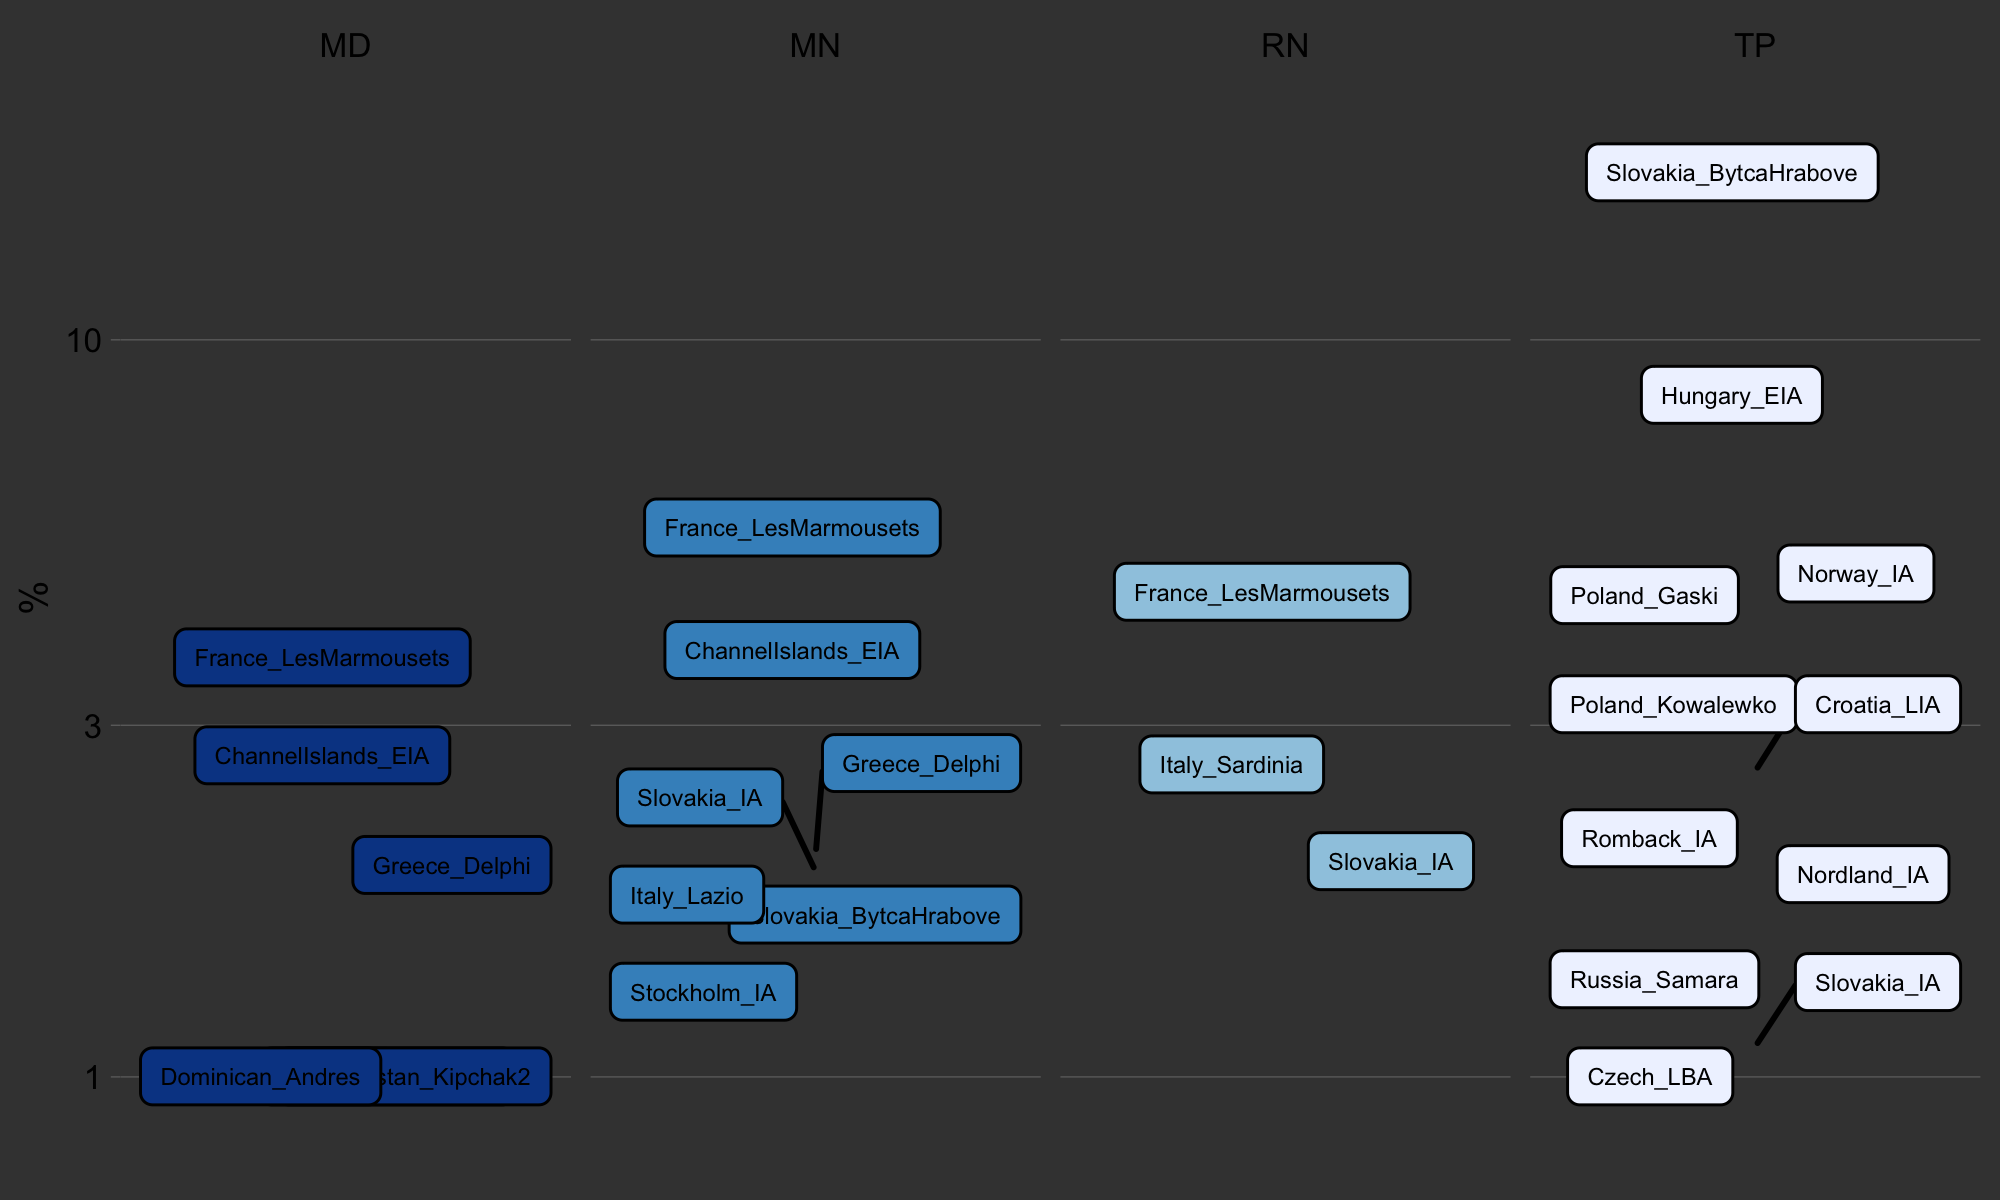

In [88]:
plotfun(mprd,lsz = 1.5)

In [67]:
mprd = mypfun(mdl,iad,smpls)

[1] "Using 124 populations"


Joining with `by = join_by(variable)`


                     name                           eth value
1    Ashkenazi_Belarussia                   Armenia_LBA  1.4%
2    Ashkenazi_Belarussia                 Italy_Tuscany  1.4%
3    Ashkenazi_Belarussia                  Iran_Hasanlu  1.4%
4    Ashkenazi_Belarussia                   Slovakia_IA  1.3%
5    Ashkenazi_Belarussia          France_LesMarmousets  1.3%
6    Ashkenazi_Belarussia                   Italy_Lazio  1.2%
7    Ashkenazi_Belarussia           Kyrgyzstan_TianShan  1.1%
8    Ashkenazi_Belarussia             Moldova_Cimmerian  1.1%
9    Ashkenazi_Belarussia              Kazakstan_Sargat  1.1%
10   Ashkenazi_Belarussia                     Spain_EIA  1.1%
11   Ashkenazi_Belarussia                     Israel_IA    1%
12   Ashkenazi_Belarussia               Iran_HajjiFiruz    1%
13   Ashkenazi_Belarussia                 Montenegro_IA    1%
14   Ashkenazi_Belarussia                  Scotland_MIA    1%
15   Ashkenazi_Belarussia                  Mongolia_Uvs    1%
16   Ash

In [204]:
options(repr.plot.width = 12, repr.plot.height = 12, repr.plot.res = 400)

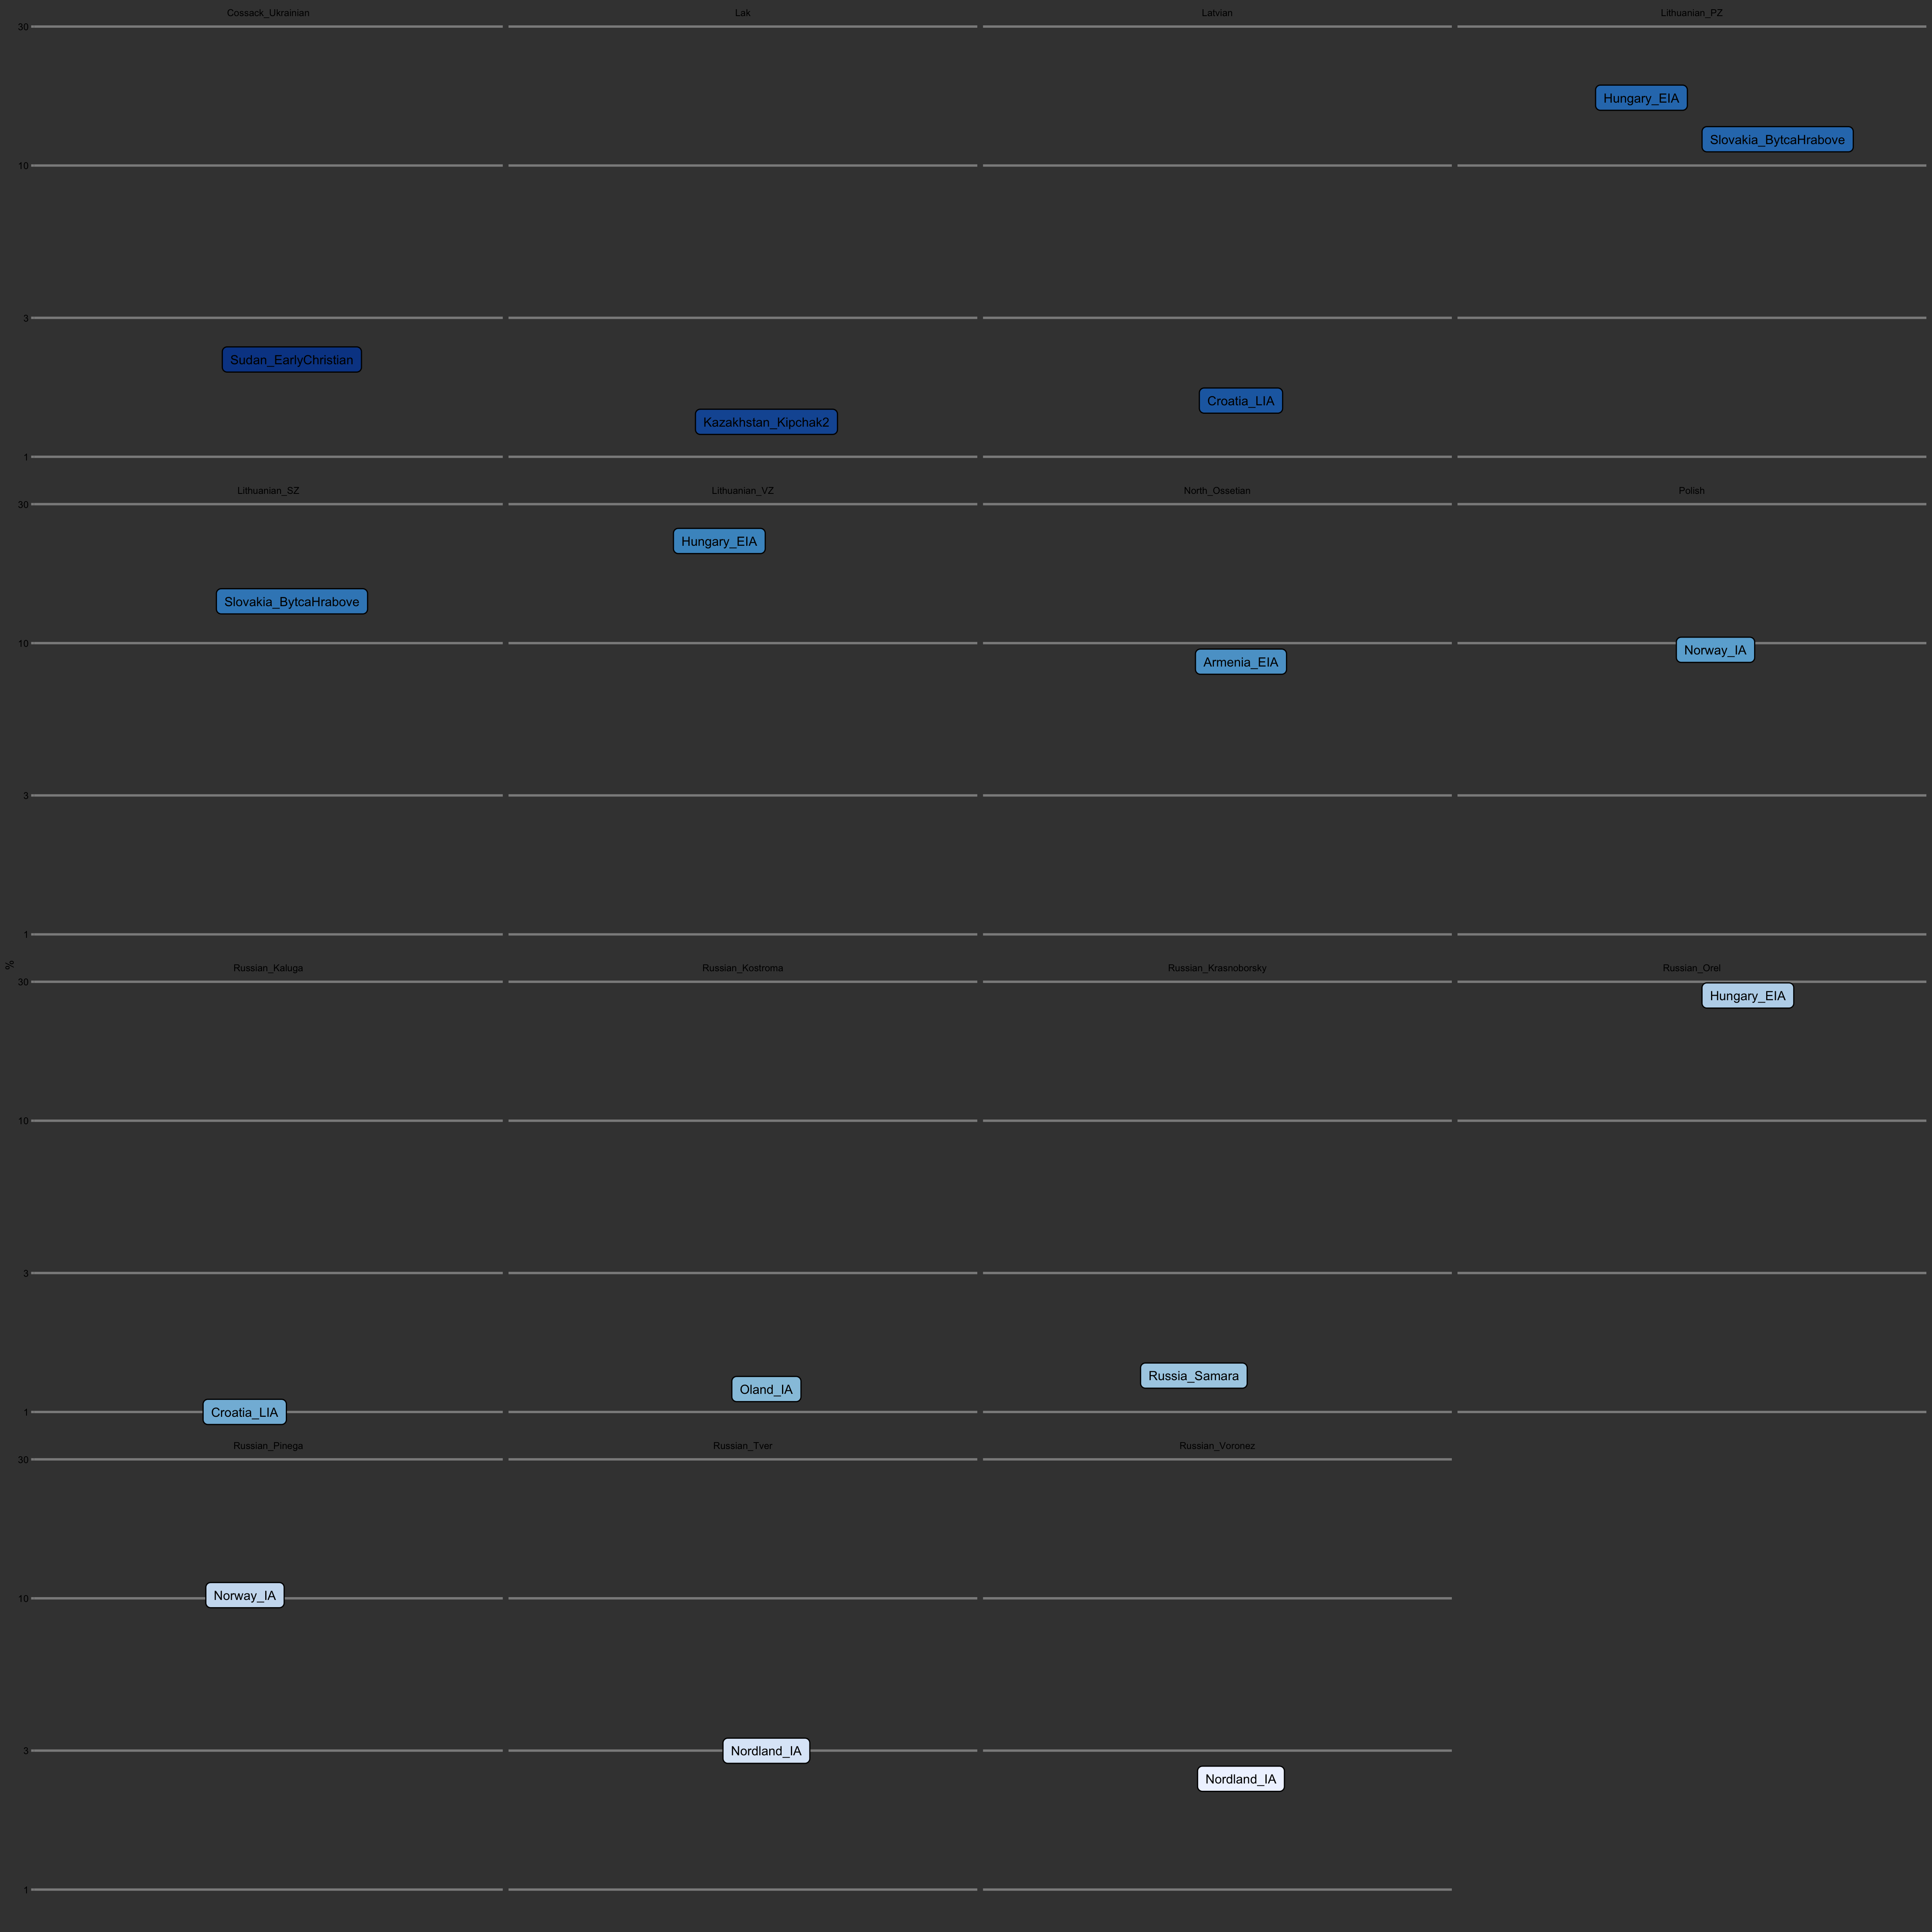

In [205]:
plotfun(mprd %>% sample_n(16),lsz = 2,nrw = 4)

Middle Ages

In [89]:
mdl = myfun(na.omit(mad),e = 1,a = 0,l = 15)

[1] "Number of classes: 163"
[1] "Split into test and train samples"
[1] 789  26
[1] 264  26
[1] "Starting XGBoost training"
[1]	train-mlogloss:4.448995	test-mlogloss:4.432860 
[26]	train-mlogloss:1.883234	test-mlogloss:3.456509 
[51]	train-mlogloss:1.262588	test-mlogloss:3.468802 
[76]	train-mlogloss:0.971467	test-mlogloss:3.492709 
[100]	train-mlogloss:0.827297	test-mlogloss:3.568905 
# A tibble: 15 × 5
     row label variable value maxval
   <int> <dbl> <chr>    <dbl>  <dbl>
 1   175   107 146      0.181  0.181
 2    18    29 59       0.763  0.763
 3   259   156 155      0.141  0.141
 4   171   104 146      0.650  0.650
 5   132    82 82       0.214  0.214
 6    76    40 40       0.427  0.427
 7   230   146 146      0.591  0.591
 8    67    39 35       0.150  0.150
 9    31    35 35       0.403  0.403
10   197   128 162      0.964  0.964
11   116    66 146      0.228  0.228
12   196   123 83       0.250  0.250
13    96    59 59       0.214  0.214
14   250   146 104      0.374  0.374

In [90]:
mprd = mypfun(mdl,mad,ppl)

[1] "Using 163 populations"


Joining with `by = join_by(variable)`


   name                        eth value
1    RN                Italy_Lazio 15.8%
2    RN        Turkey_PostMedieval  3.1%
3    RN           Portugal_Miroico  2.3%
4    RN            Serbia_Medieval  2.2%
5    RN           Italy_Basilicata  2.2%
6    RN BosniaHerzegovina_Medieval  1.9%
7    RN            Israel_Medieval  1.8%
8    RN            Kyrgyzstan_Saka  1.6%
9    RN             Slovenia_Emona  1.4%
10   RN            Turkey_Medieval  1.3%
11   RN             Italy_Sardinia  1.2%
12   RN               Mongolia_Uvs  1.2%
13   RN       Mongolia_Ulaanbaatar  1.1%
14   RN               Croatia_Metz    1%
15   RN               Poland_Rumin    1%
16   TP         Sweden_EarlyViking 26.8%
17   TP             Poland_Konskie 19.2%
18   TP          Poland_Oblaczkowo  1.8%
19   TP        Poland_Dziekanowice  1.7%
20   TP            Poland_Balczewo  1.4%
21   TP               Poland_Rumin  1.4%
22   TP              Poland_Ostrow  1.3%
23   TP                 Poland_Lad  1.1%
24   TP         

In [72]:
options(repr.plot.width = 5, repr.plot.height = 3, repr.plot.res = 400)

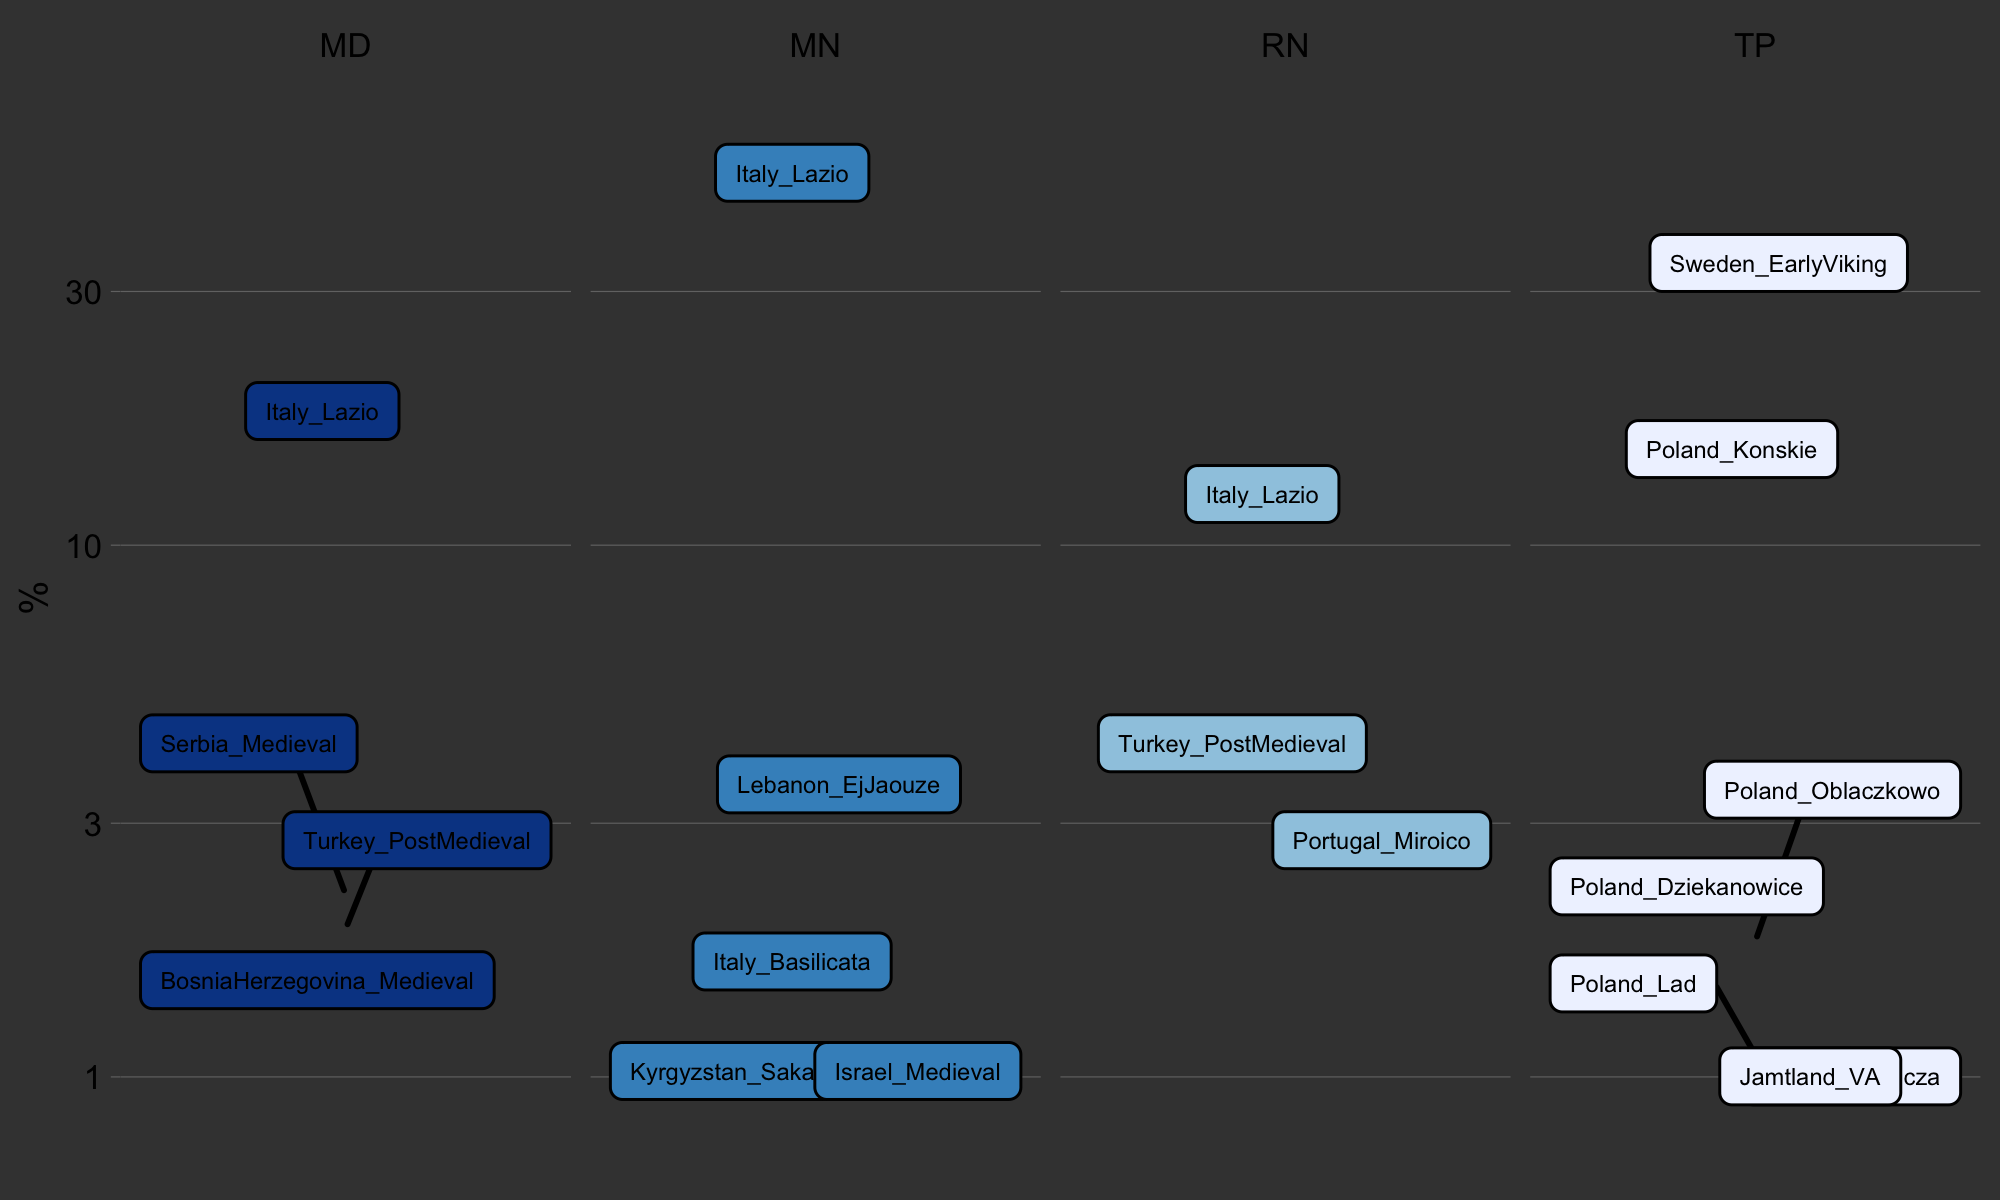

In [91]:
plotfun(mprd,lsz = 1.5)

In [93]:
mprd = mypfun(mdl,mad,smpls)

[1] "Using 163 populations"


Joining with `by = join_by(variable)`


                     name                           eth value
1    Ashkenazi_Belarussia                   Italy_Lazio 66.9%
2     Ashkenazi_Lithuania                   Italy_Lazio 51.7%
3     Ashkenazi_Lithuania               Kyrgyzstan_Saka  1.6%
4     Ashkenazi_Lithuania               Israel_Medieval  1.5%
5     Ashkenazi_Lithuania              Portugal_Miroico  1.1%
6     Ashkenazi_Lithuania    BosniaHerzegovina_Medieval    1%
7       Ashkenazi_Ukraine                   Italy_Lazio 51.2%
8       Ashkenazi_Ukraine               Kyrgyzstan_Saka  1.7%
9              Belarusian                Poland_Konskie    7%
10             Belarusian                 Poland_Milicz  6.4%
11             Belarusian            Sweden_EarlyViking  5.3%
12             Belarusian                Poland_Niemcza  3.6%
13             Belarusian                    Poland_Lad  3.3%
14             Belarusian             Poland_Oblaczkowo  3.3%
15             Belarusian               Poland_Balczewo  2.9%
16      

In [212]:
options(repr.plot.width = 12, repr.plot.height = 12, repr.plot.res = 400)

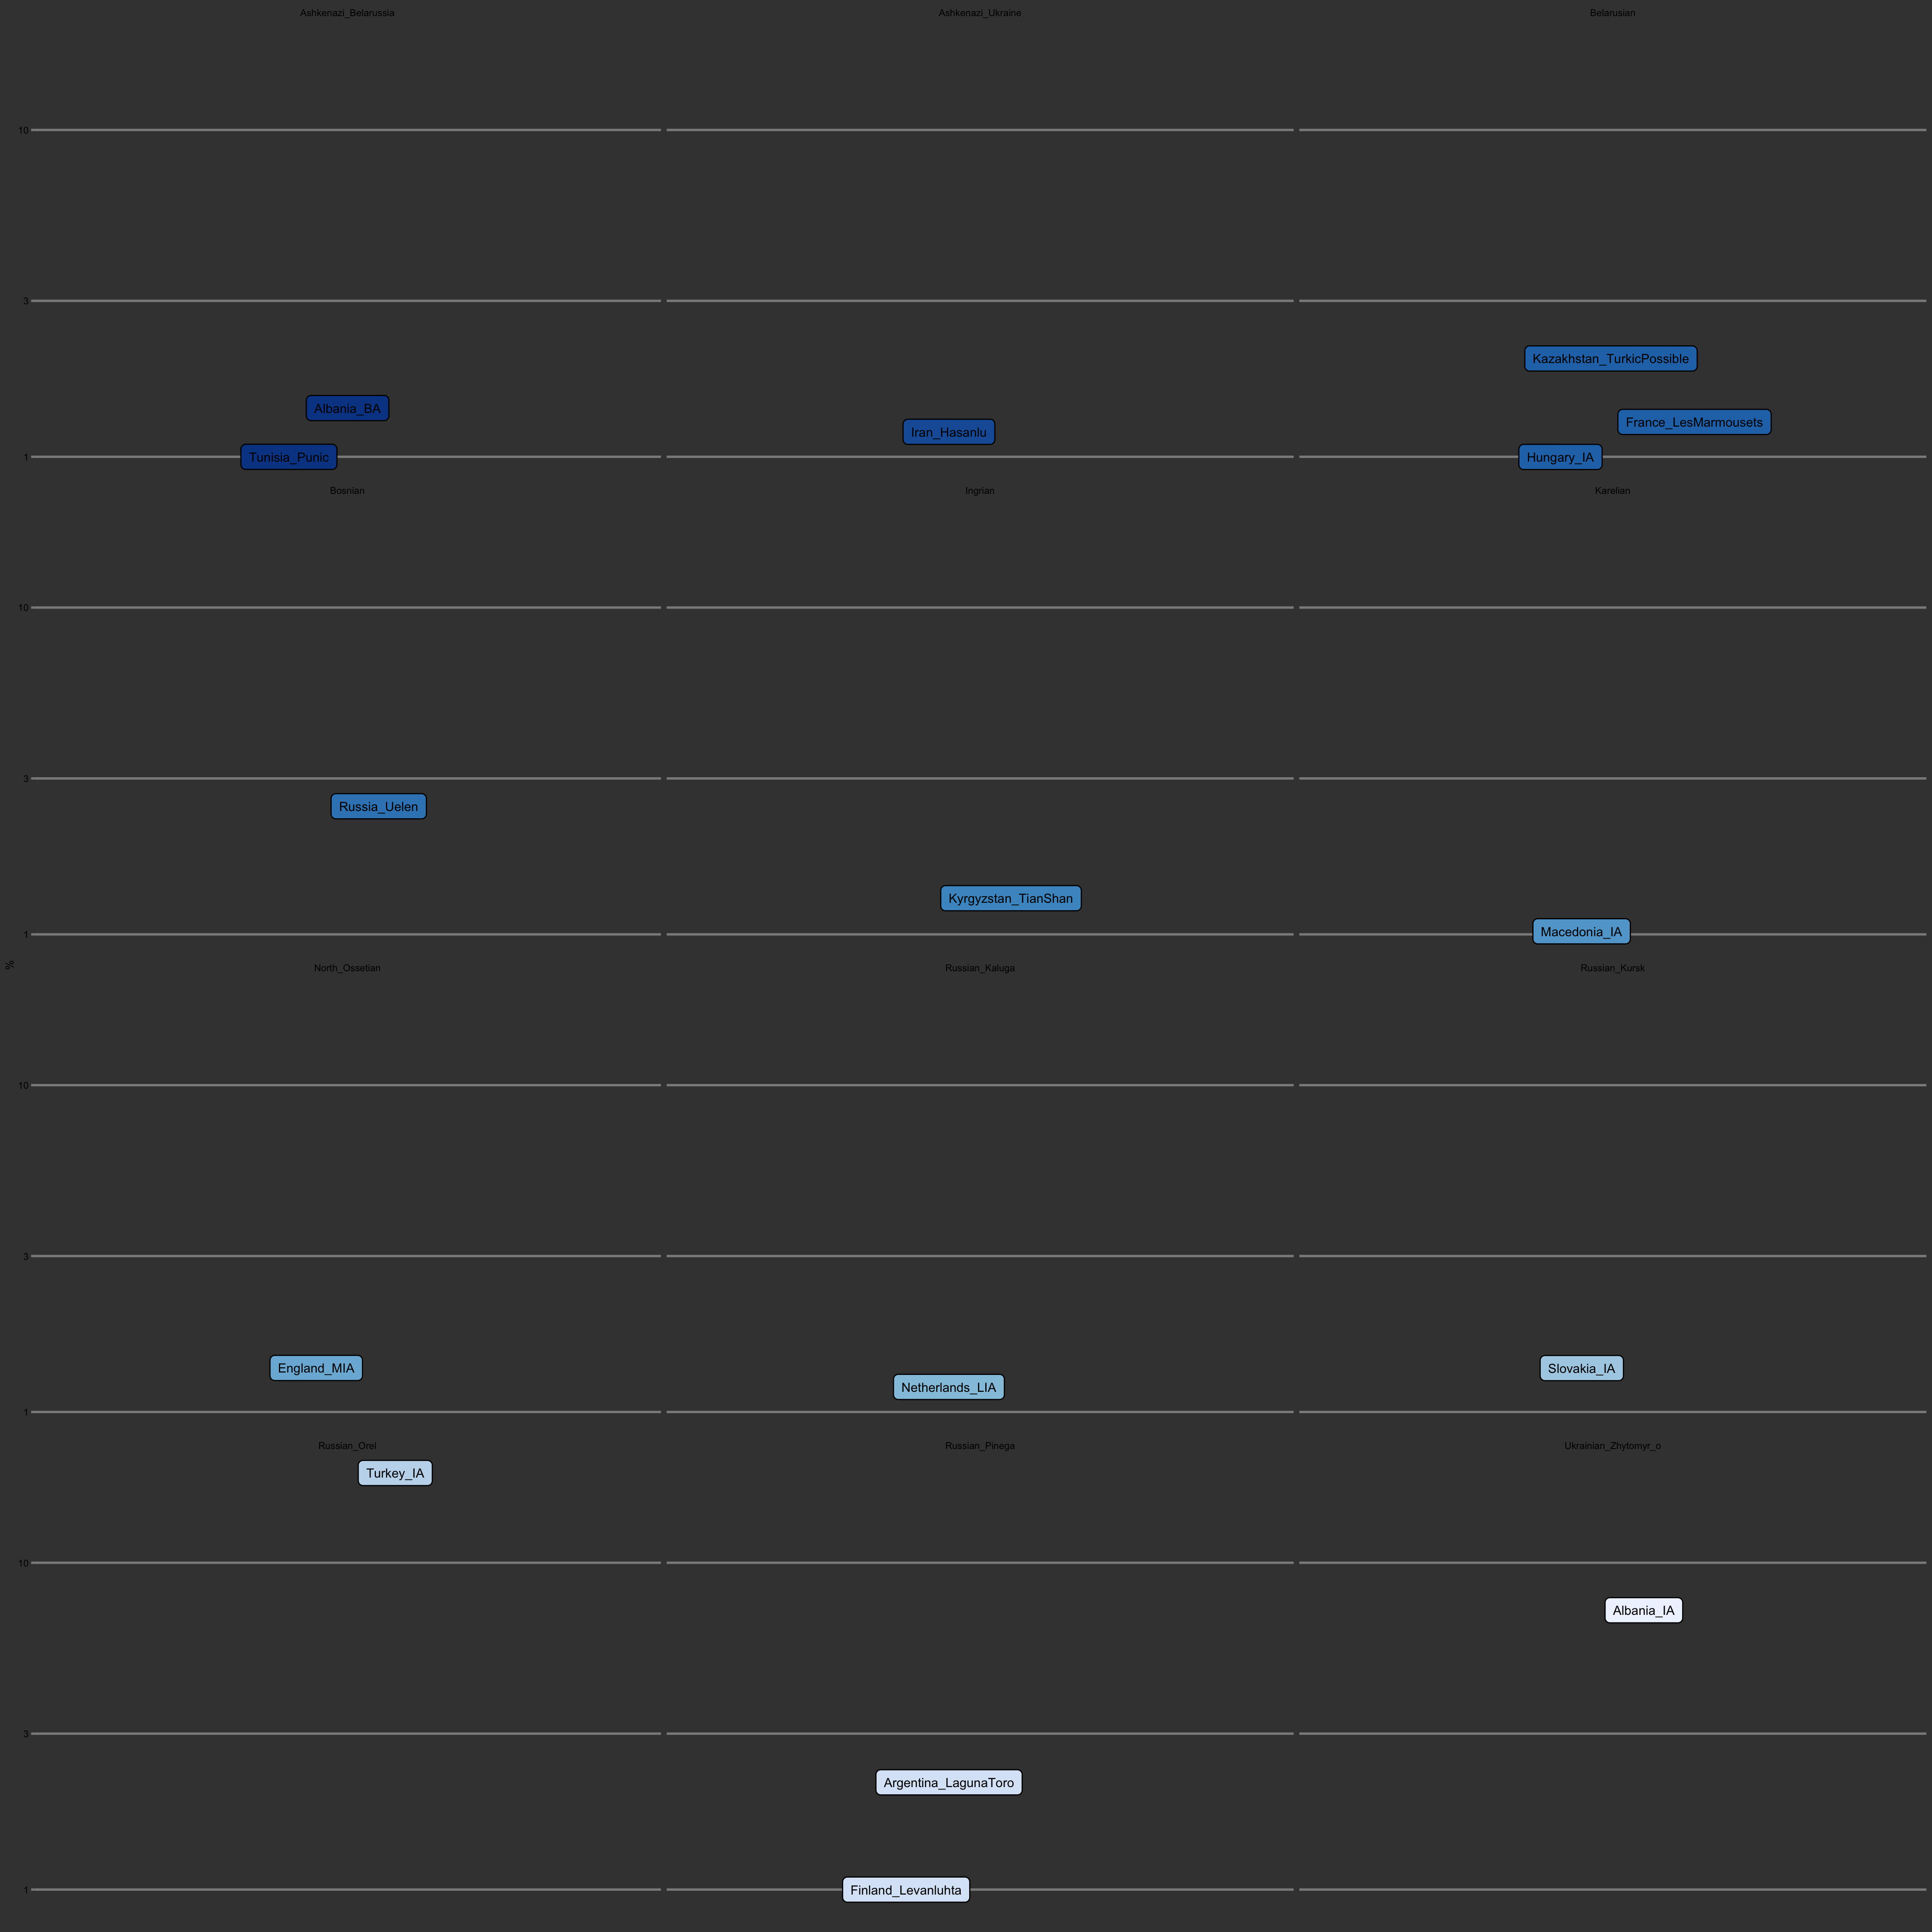

In [213]:
plotfun(mprd %>% sample_n(16),lsz = 2,nrw = 4)